In [77]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import yfinance as yf

# For model specification
from ISLP.models import ModelSpec as MS

# Settings
plt.style.use('Solarize_Light2')

[*********************100%***********************]  3 of 3 completed


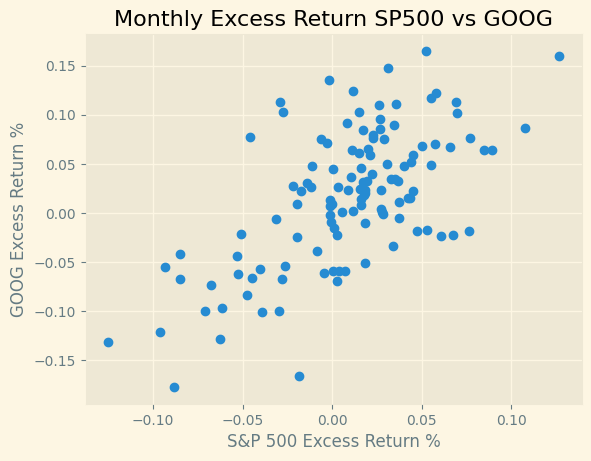

Ticker        GOOG       ^GSPC        ^IRX  ^GSPC_excess  GOOG_excess
count   119.000000  119.000000  119.000000    119.000000   119.000000
mean      0.018270    0.010500    0.001796      0.008705     0.016474
std       0.069341    0.043791    0.001660      0.043761     0.069316
min      -0.176750   -0.125119    0.000002     -0.125144    -0.177421
25%      -0.020789   -0.010517    0.000226     -0.013024    -0.022958
50%       0.023957    0.017859    0.001324      0.015718     0.022002
75%       0.068205    0.035692    0.003793      0.034873     0.066209
max       0.165080    0.126844    0.004329      0.126769     0.165078


In [78]:
# Download closing data
# NOTE: the 13-week T-bill is a proxy for the risk free rate, as the 1M T-bill rate is not available from Yahoo Finance
tickers = ['^GSPC', 'GOOG', '^IRX']
data = yf.download(tickers, period='10y', interval='1mo', auto_adjust=True)['Close']

# Convert interest rate to monthly basis
# Deal with missing interest rates with forward fill
data['^IRX'] = data['^IRX'] / 100
data['^IRX'] = (1 + data['^IRX']) ** (1 / 12) - 1
data['^IRX'] = data['^IRX'].ffill()

# Calculate the monthly return
data[['^GSPC', 'GOOG']] = data[['^GSPC', 'GOOG']].pct_change()

# Calculate excess returns
data['^GSPC_excess'] = data['^GSPC'] - data['^IRX']
data['GOOG_excess'] = data['GOOG'] - data['^IRX']

data.dropna(inplace=True)

# Create a scatter plot
plt.scatter(data['^GSPC_excess'], data['GOOG_excess'])
plt.title('Monthly Excess Return SP500 vs GOOG')
plt.xlabel('S&P 500 Excess Return %')
plt.ylabel('GOOG Excess Return %')
plt.show()

print(data.describe())

In [79]:
X = MS(['^GSPC']).fit_transform(data)
y = data['GOOG']

# Create the index model
index_model = sm.OLS(y, X)
results = index_model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     81.17
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           4.65e-15
Time:                        15:50:24   Log-Likelihood:                 180.58
No. Observations:                 119   AIC:                            -357.2
Df Residuals:                     117   BIC:                            -351.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.005      1.512      0.1

Index Model RSE:        0.0537
Index Model Pct. Error: 77.8242%
Residual Mean:          0.0000
Residual Skewness:      0.1493
Residual Kurtosis:      0.2117


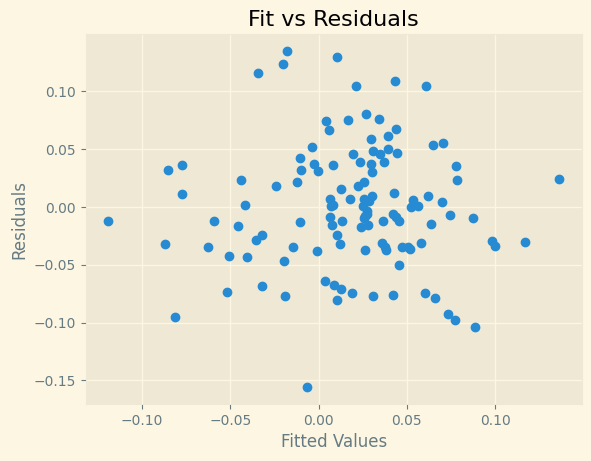

In [80]:
n = len(y)
p = X.shape[1] # Number of model parameters

RSS = sum(results.resid ** 2)       # Residual sum of squares
RSE = np.sqrt(RSS / (n - p - 1))    # Residual standard error
pct_error = (RSE / np.std(y)) * 100 # Percentage error

# Residual statistics
resid_mean = np.mean(results.resid)
resid_skew = st.skew(results.resid)
resit_kurt = st.kurtosis(results.resid)

# Print the model statistics
print(f'Index Model RSE:        {RSE:.4f}')
print(f'Index Model Pct. Error: {pct_error:.4f}%')
print(f'Residual Mean:          {resid_mean:.4f}')
print(f'Residual Skewness:      {resid_skew:.4f}')
print(f'Residual Kurtosis:      {resit_kurt:.4f}')

# Plot the fitted values against the residuals
plt.scatter(results.fittedvalues, results.resid)
plt.title('Fit vs Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()